In [2]:
!pip install tsfel

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 47.6 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [1]:
!pip install pandas==1.5.3
!pip install tsfel

In [2]:
!pip install keras_tuner

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
import datetime

import sklearn
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, precision_recall_curve, auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn import preprocessing, metrics
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, VarianceThreshold

import torch
import torch.nn as nn
import torch.utils.data as data_utils

import tensorflow as tf
import keras_tuner
import tsfel

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.cm as cm

np.random.seed(0)
tf.random.set_seed(0)

In [4]:
!git clone https://github.com/MLinApp-FP01-Team7-24/OurProject.git
%cd OurProject

Cloning into 'OurProject'...
remote: Enumerating objects: 3274, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 3274 (delta 28), reused 5 (delta 4), pack-reused 3214 (from 1)
Receiving objects: 100% (3274/3274), 668.04 MiB | 19.28 MiB/s, done.
Resolving deltas: 100% (684/684), done.
Updating files: 100% (2152/2152), done.
/content/OurProject


# Data load

In [ ]:
# Set widnow size and k for point adjustment. 1 is f1, 0 is f1_pa

window_size = 20
k_pa = 1

In [ ]:
from Models.lstm_vae.data import get_data_windows

# Get data for training, calibration and testing in form of numpy arrays. Already windowed and normalized.
data_train, data_cal, label_cal, data_test, label_test = get_data_windows(window_size, k_pa)

print(data_train.shape)
print(data_cal.shape, label_cal.shape)
print(data_test.shape, label_test.shape)

Reading training data...
Reading calibration data...
Reading test data...
Reading collisions data...
Normalizing data...
Getting windows for training data...
Getting windows and labels for calibration data...
Getting windows and labels for test data...
(95795, 20, 55)
(3480, 20, 55) (3480,)
(30755, 20, 55) (30755,)


# KNN Baseline

In [ ]:
# prompt: data train all è un np array (n_windows,window_size,n_features) voglio farlo diventare (n_windows,windows_size*n_features) stampa shape per essere  sicuro, esegui la stessa trasformazione per data_test

data_train = data_train.reshape(data_train.shape[0], -1)
data_cal = data_cal.reshape(data_cal.shape[0], -1)
data_test = data_test.reshape(data_test.shape[0], -1)

print(data_train.shape)
print(data_cal.shape)
print(data_test.shape)


(95795, 1100)
(3480, 1100)
(30755, 1100)


In [ ]:
# Supponiamo che i dati siano in queste variabili
# X_train: dati di training (solo normali)
# X_calibration: dati di calibrazione
# y_calibration: etichette di calibrazione (0 = normale, 1 = anomalia)
# X_test: dati di test
# y_test: etichette di test (0 = normale, 1 = anomalia)

# Modello KNN
k = 1  # Numero di vicini
knn = NearestNeighbors(n_neighbors=k)
knn.fit(data_train)

# Fase di calibrazione
distances_cal, _ = knn.kneighbors(data_cal)
# # Usare la media delle distanze dai k vicini
# mean_distances_calibration = np.mean(distances_calibration, axis=1)

# Calcolare la soglia basata sui dati di calibrazione
# Esempio: possiamo scegliere la soglia come la distanza massima delle istanze normali
# threshold = np.max(mean_distances_calibration[label_cal == 0])


In [ ]:
optimize = False
param_grid = {'estimator__C': np.logspace(0, 5, 6), 'estimator__gamma': np.logspace(-5, 0, 6)}

if optimize:
  cal_search = GridSearchCV(CalibratedClassifierCV(SVC(probability=True), cv=3), param_grid, cv=3, verbose=1, scoring='f1')
  cal_search.fit(distances_cal, label_cal)
  cal_model = cal_search.best_estimator_
  print(cal_search.best_params_)
else:
  cal_model = CalibratedClassifierCV(SVC(probability=True, C=10e4, gamma=1))
  cal_model.fit(distances_cal, label_cal[:distances_cal.shape[0]])

Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'estimator__C': 10000.0, 'estimator__gamma': 1.0}


In [ ]:
# Fase di test
distances_test, _ = knn.kneighbors(data_test)
# mean_distances_test = np.mean(distances_test, axis=1)
y_pred_test = cal_model.predict(distances_test)

# Utilizza predict_proba per ottenere le probabilità di appartenenza alle classi
confidence = cal_model.predict_proba(distances_test)

# Se stai facendo una classificazione binaria, puoi prendere solo la seconda colonna (classe positiva)
# confidence[:, 1] rappresenta la probabilità di appartenere alla classe positiva
confidence = confidence[:, 1]

In [ ]:
# Calcolare F1 score
f1 = f1_score(label_test, y_pred_test)

# Calcolare Precision-Recall AUC
precision, recall, _ = precision_recall_curve(label_test, y_pred_test)
pr_auc = auc(recall, precision)

# Calcolare AUROC
roc_auc = roc_auc_score(label_test, y_pred_test)

# Stampa dei risultati
print(f"F1 Score: {f1}")
print(f"PR AUC: {pr_auc}")
print(f"ROC AUC: {roc_auc}")

F1 Score: 0.4185960363030191
PR AUC: 0.5412195614792118
ROC AUC: 0.845399437184783


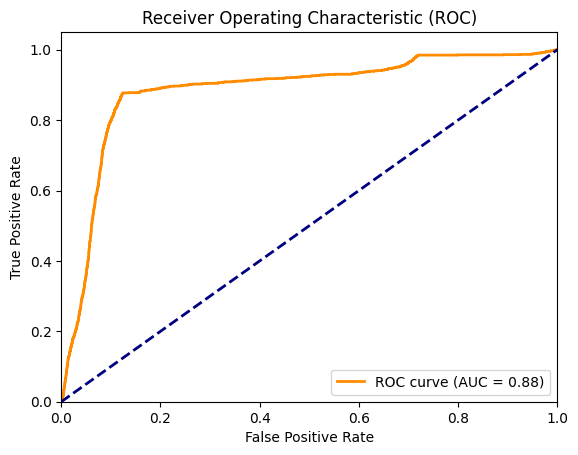

In [ ]:
# Step 4: Compute ROC curve and AUC score
fpr_knn, tpr_knn, thresholds = roc_curve(label_test, confidence)  # fpr = False positive rate, tpr = True positive rate
roc_auc = auc(fpr_knn, tpr_knn)  # Compute Area Under the Curve (AUC)
# Save fpr and tpr as a .npz file
np.savez('/content/OurProject/fpr_tpr_KNN.npz', fpr=fpr_knn, tpr=tpr_knn)
# Step 5: Plot ROC curve
plt.figure()
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

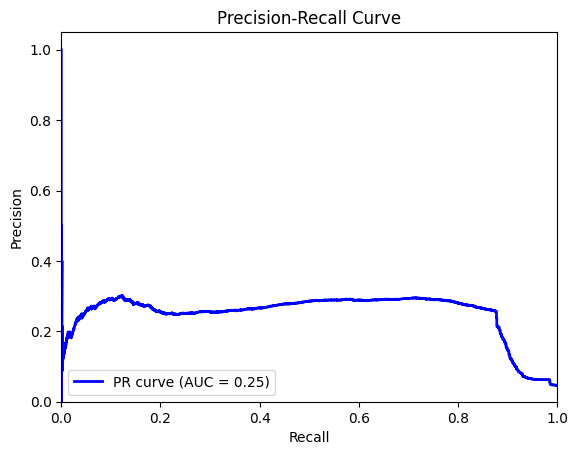

In [ ]:
# Step 4: Compute Precision-Recall curve and AUC score
precision_knn, recall_knn, thresholds = precision_recall_curve(label_test, confidence)
pr_auc = auc(recall_knn, precision_knn)  # Compute Area Under the PR Curve (AUPRC)
# Save fpr and tpr as a .npz file
np.savez('/content/OurProject/pr_rc_KNN.npz', precision=precision_knn, recall=recall_knn)

# Step 5: Plot Precision-Recall curve
plt.figure()
plt.plot(recall_knn, precision_knn, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Bayesian

In [ ]:
ROOTDIR_DATASET_NORMAL = "/content/OurProject/kuka_dataset/normal"

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [ ]:
def seaborn_cm(cm, ax, tick_labels, fontsize=14, title=None, sum_actual="over_columns",
               xrotation=0, yrotation=0):
    """
    Function to plot a confusion matrix
    """
    from matplotlib import cm as plt_cmap
    group_counts = ["{:0.0f}".format(value) for value in cm.flatten()]
    if sum_actual == "over_columns":
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    elif sum_actual == "over_rows":
        cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
    else:
        print("sum_actual must be over_columns or over_rows")
        exit()
    cm = np.nan_to_num(cm)
    mean_acc = np.mean(np.diag(cm)[cm.sum(axis=1) != 0])
    std_acc = np.std(np.diag(cm))
    group_percentages = ["{:0.0f}".format(value*100) for value in cm.flatten()]
    cm_labels = [f"{c}\n{p}%" for c, p in zip(group_counts, group_percentages)]
    cm_labels = np.asarray(cm_labels).reshape(len(tick_labels), len(tick_labels))
    sns.heatmap(cm,
                ax=ax,
                annot=cm_labels,
                fmt='',
                cbar=False,
                cmap=plt_cmap.Greys,
                linewidths=1, linecolor='black',
                annot_kws={"fontsize": fontsize},
                xticklabels=tick_labels,
                yticklabels=tick_labels)
    ax.set_yticklabels(ax.get_yticklabels(), size=fontsize, rotation=yrotation)
    ax.set_xticklabels(ax.get_xticklabels(), size=fontsize, rotation=xrotation)
    if title:
        title = f"{title}\nMean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    else:
        title = f"Mean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    ax.set_title(title)
    if sum_actual == "over_columns":
        ax.set_ylabel("Actual")
        ax.set_xlabel("Predicted")
    else:
        ax.set_ylabel("Predicted")
        ax.set_xlabel("Actual")
    ax.axis("off")

In [ ]:
def get_df_action(filepaths_csv, filepaths_meta, action2int=None, delimiter=";"):
    # Load dataframes
    print("Loading data.")
    # Make dataframes
    # Some classes show the output boolean parameter as True rather than true. Fix here
    dfs_meta = list()
    for filepath in filepaths_meta:
        df_m = pd.read_csv(filepath, sep=delimiter)
        df_m.str_repr = df_m.str_repr.str.replace('True', 'true')
        df_m['filepath'] = filepath
        dfs_meta.append(df_m)

    df_meta = pd.concat(dfs_meta)
    df_meta.index = pd.to_datetime(df_meta.init_timestamp.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    df_meta['completed_timestamp'] = pd.to_datetime(df_meta.completed_timestamp.astype('datetime64[ms]'),
                                                    format="%Y-%m-%dT%H:%M:%S.%f")
    df_meta['init_timestamp'] = pd.to_datetime(df_meta.init_timestamp.astype('datetime64[ms]'),
                                               format="%Y-%m-%dT%H:%M:%S.%f")

    # Eventually reduce number of classes
    # df_meta['str_repr'] = df_meta.str_repr.str.split('=', expand = True,n=1)[0]
    # df_meta['str_repr'] = df_meta.str_repr.str.split('(', expand=True, n=1)[0]

    actions = df_meta.str_repr.unique()
    dfs = [pd.read_csv(filepath_csv, sep=";") for filepath_csv in filepaths_csv]
    df = pd.concat(dfs)

    # Sort columns by name !!!
    df = df.sort_index(axis=1)

    # Set timestamp as index
    df.index = pd.to_datetime(df.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    # Drop useless columns
    columns_to_drop = [column for column in df.columns if "Abb" in column or "Temperature" in column]
    df.drop(["machine_nameKuka Robot_export_active_energy",
             "machine_nameKuka Robot_import_reactive_energy"] + columns_to_drop, axis=1, inplace=True)
    signals = df.columns

    df_action = list()
    for action in actions:
        for index, row in df_meta[df_meta.str_repr == action].iterrows():
            start = row['init_timestamp']
            end = row['completed_timestamp']
            df_tmp = df.loc[start: end].copy()
            df_tmp['action'] = action
            # Duration as string (so is not considered a feature)
            df_tmp['duration'] = str((row['completed_timestamp'] - row['init_timestamp']).total_seconds())
            df_action.append(df_tmp)
    df_action = pd.concat(df_action, ignore_index=True)
    df_action.index = pd.to_datetime(df_action.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    df_action = df_action[~df_action.index.duplicated(keep='first')]

    # Drop NaN
    df = df.dropna(axis=0)
    df_action = df_action.dropna(axis=0)

    if action2int is None:
        action2int = dict()
        j = 1
        for label in df_action.action.unique():
            action2int[label] = j
            j += 1

    df_merged = df.merge(df_action[['action']], left_index=True, right_index=True, how="left")
    # print(f"df_merged len: {len(df_merged)}")
    # Where df_merged in NaN Kuka is in idle state
    df_idle = df_merged[df_merged['action'].isna()].copy()
    df_idle['action'] = 'idle'
    df_idle['duration'] = df_action.duration.values.astype(float).mean().astype(str)
    df_action = pd.concat([df_action, df_idle])

    # ile label must be 0 for debug mode
    action2int['idle'] = 0
    print(f"Found {len(set(df_action['action']))} different actions.")
    print("Loading data done.\n")

    return df_action, df, df_meta, action2int

In [ ]:
!ls {ROOTDIR_DATASET_NORMAL}

rec0_20220811_rbtc_0.1s.csv	  rec3_20220811_rbtc_0.1s.csv
rec0_20220811_rbtc_0.1s.metadata  rec3_20220811_rbtc_0.1s.metadata
rec2_20220811_rbtc_0.1s.csv	  rec4_20220811_rbtc_0.1s.csv
rec2_20220811_rbtc_0.1s.metadata  rec4_20220811_rbtc_0.1s.metadata


In [ ]:
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_0.1s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_0.1s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.



In [ ]:
df_action.head(2)

,machine_nameKuka Robot_apparent_power,machine_nameKuka Robot_current,machine_nameKuka Robot_export_reactive_energy,machine_nameKuka Robot_frequency,machine_nameKuka Robot_import_active_energy,machine_nameKuka Robot_phase_angle,machine_nameKuka Robot_power,machine_nameKuka Robot_power_factor,machine_nameKuka Robot_reactive_power,machine_nameKuka Robot_voltage,...,sensor_id5_AccZ,sensor_id5_AngX,sensor_id5_AngY,sensor_id5_AngZ,sensor_id5_GyroX,sensor_id5_GyroY,sensor_id5_GyroZ,time,action,duration
time,,,,,,,,,,,,,,,,,,,,,
2022-08-11 13:09:50.319,165.617218,0.976074,1383.394043,49.951218,1618.833008,319.896576,126.683266,0.764916,-106.669258,228.842468,...,309.87,248.15,350.14,328.11,0.0,0.0,0.0,2022-08-11T13:09:50.319094+00:00,"pickFromPallet(2,2)=[true,1,0]",12.052
2022-08-11 13:09:50.419,165.617218,0.976074,1383.394043,49.951218,1618.833008,319.896576,126.683266,0.764916,-106.669258,228.842468,...,309.88,248.15,350.14,328.11,0.0,0.0,0.0,2022-08-11T13:09:50.419094+00:00,"pickFromPallet(2,2)=[true,1,0]",12.052


In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

def get_features_ts(domain, df_action, df_meta, frequency, action2int):
    duration_dict = {1: 10, 10: 1, 100: 0.1, 200: 0.05}
    duration_min = duration_dict[int(frequency)]
    cfg = tsfel.get_features_by_domain(domain)
    dataframe_features = list()
    print("Computing features.")
    # Idle does not have associated timestamps. Window is set to 10 seconds
    df_by_action = df_action[df_action["action"] == "idle"].copy()
    X = tsfel.time_series_features_extractor(cfg,
                                             df_by_action.select_dtypes(['number']),
                                             fs=frequency,
                                             header_names=df_by_action.select_dtypes(['number']).columns + '-',
                                             window_size=20,#int(frequency * 10),
                                             verbose=False)
    time = pd.to_datetime(df_by_action.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    X['start'] = [t[0] for t in
                  tsfel.utils.signal_processing.signal_window_splitter(time, window_size=20)]
    X['duration'] = 2#sec
    X['end'] = X['start'] + pd.to_timedelta(X['duration'], 's')
    X['label'] = action2int["idle"]
    X.drop('duration', inplace=True, axis=1)
    dataframe_features.append(X)
    actions = list(df_action.action.unique())
    actions.remove("idle")
    for action in actions:
        df_by_action = df_action[df_action["action"] == action].copy()
        df_meta_by_action = df_meta[df_meta['str_repr'] == action].copy()
        df_meta_by_action['start'] = pd.to_datetime(df_meta_by_action.init_timestamp.astype('datetime64[ms]'),
                                                    format="%Y-%m-%dT%H:%M:%S.%f")
        df_meta_by_action['end'] = pd.to_datetime(
            df_meta_by_action.completed_timestamp.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
        for _, row in df_meta_by_action.iterrows():
            df_by_action_by_event = df_by_action.loc[row["start"]: row["end"]]
            if len(df_by_action_by_event) < duration_min * frequency:
                print(f"Skipped feature extraction for {action} {row['start']} : {row['end']}.")
                continue

            X = tsfel.calc_window_features(cfg,
                                           df_by_action_by_event.select_dtypes(['number']),
                                           header_names=df_by_action_by_event.select_dtypes(['number']).columns + '-',
                                           fs=frequency,
                                           verbose=False)
            # print(X.shape)
            X['label'] = action2int[action]
            X['start'] = row['start']
            X['end'] = row['end']
            dataframe_features.append(X)

    dataframe_features = pd.concat(dataframe_features)
    print("Computing features done.")
    return dataframe_features

In [ ]:
start_time = time.time()
df_features = get_features_ts("statistical", df_action, df_meta, 10, action2int)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
--- 210.04502534866333 seconds ---


In [ ]:
df_features.isnull().values.any()

True

In [ ]:
# df_features_nonan = df_features.drop((df_features.columns[df_features.isna().any()].tolist()), axis=1)
df_features_nonan = df_features.fillna(0)

In [ ]:
df_train, df_test = train_test_split(df_features_nonan)

In [ ]:
X_train = df_train.drop(["label", "start", "end"], axis=1)
y_train = df_train["label"]
X_test = df_test.drop(["label", "start", "end"], axis=1)
y_test = df_test["label"]

In [ ]:
# Normalise features
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

# Remove zero-variance features
selector_variance = VarianceThreshold()
selector_variance.fit(X_train)
X_train = pd.DataFrame(selector_variance.transform(X_train),
                        columns=X_train.columns.values[selector_variance.get_support()])

# Remove highly correlated features
corr_features = tsfel.correlated_features(X_train,
                                          threshold=0.95)
X_train.drop(corr_features, inplace=True, axis=1)

# Lasso selector
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
lasso = SelectFromModel(lsvc, prefit=True)
selected_features = X_train.columns.values[lasso.get_support()]
X_train = X_train[selected_features].copy()

# Labels
num_classes = len(set(y_train))
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

# Test
X_test = pd.DataFrame(selector_variance.transform(scaler.transform(X_test)),
                      columns=X_test.columns.values[selector_variance.get_support()])
X_test.drop(corr_features, inplace=True, axis=1)
X_test = X_test[selected_features].copy()

In [ ]:
# Create the MLP tf model
def build_model(hp):

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
    hp_drop_rate = hp.Float('drop_rate', min_value=0.1, max_value=0.75, step=32)
    hp_drop_rate_last = hp.Float('drop_rate', min_value=0.1, max_value=0.75, step=32)
    inputs = tf.keras.layers.Input(shape=(X_train.values.shape[1],))
    x = inputs
    for i in range(hp.Int("mlp_layers", 1, 3)):
        x = tf.keras.layers.Dense(
            units=hp.Int(f"units_{i}", 32, 128, step=32), activation="relu",
        )(x)
        x = tf.keras.layers.Dropout(rate=hp_drop_rate)(x, training=True)
    x = tf.keras.layers.Dropout(rate=0.5)(x, training=True)
    x = tf.keras.layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    tf_model = tf.keras.Model(inputs=inputs, outputs=x)
    tf_model.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                        metrics=['accuracy'])
    return tf_model

In [ ]:
# Hyperparams setting
DIR_OUTPUT = "/content/models"
try:
    os.makedirs(DIR_OUTPUT)
except FileExistsError:
    print(f"{DIR_OUTPUT} exists yet.")
tuner = keras_tuner.Hyperband(
    build_model,
    overwrite=True,
    objective='accuracy',
    max_epochs=50,
    factor=3,
    directory=os.path.join(DIR_OUTPUT, "keras_tuner"),
    project_name="keras_tuner_prj")

stop_early = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=15)
print("Grid search training.")
tuner.search(X_train.values, y_train_categorical, epochs=50,
             callbacks=[stop_early,tf.keras.callbacks.TensorBoard(
                 os.path.join(DIR_OUTPUT, "/tmp/tb_logs"))])

Trial 90 Complete [00h 00m 10s]
accuracy: 0.36231884360313416

Best accuracy So Far: 0.966183602809906
Total elapsed time: 00h 15m 07s


In [ ]:
classifier = tuner.get_best_models()[0]
y_test_predict = classifier.predict(X_test.values)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [ ]:
class Confidence:

    def __init__(self, multiple_preds):
        self.multiple_preds = multiple_preds
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def compute_uncertainty_metrics(self):
        return {metric: self._compute_uncertainty(
            metric,
            self.multiple_preds) for metric in self._uncertainty_metrics.keys()}

    def _normalize(self, values):
            return (values - values.min())/(values.max()-values.min())

    def _compute_uncertainty(self, metric, multiple_preds):
        try:
            print("Done {}".format(metric))
            return self._normalize(
                self._uncertainty_metrics[metric](multiple_preds))
        except KeyError:
            print("{} not implemented.".format(metric))

    def _avreage_prediction(self, multiple_preds):
        if len(multiple_preds.shape) > 2:
            return np.mean(np.array(multiple_preds), axis=0)
        else:
            return multiple_preds

    def _entropy(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        eps = 1e-5
        entropy = -1 * np.sum(avg_preds * np.log(avg_preds + eps), axis=1)
        return entropy

    def _variance(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return  np.var(avg_preds, axis=1)

    def _max_softmax_response(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return np.max(avg_preds, axis=1)

def anomaly_detection_metric(anomaly_start_timestamps, confidence, df_dataset, thresholds, less_than=True):
    "Actual is y axis"
    if not less_than:
        confidence = 1 - confidence

    sens = list()
    spec = list()
    fpr = list()
    f1 = list()
    prec = list()
    cm_list = list()
    anomaly_indexes_dict = dict()
    acc_with_err = list()
    for threshold in thresholds:
        df_not_confident = df_dataset[confidence <= threshold]
        tp = 0
        anomaly_indexes = list()
        for anomaly in anomaly_start_timestamps:
            for index, row in df_not_confident.iterrows():
                if anomaly >= row['start'] and anomaly <= row['end']:
                    anomaly_indexes.append(index)
                    tp += 1

        cm_anomaly = np.zeros((2, 2))
        n_samples = len(df_dataset)
        n_not_collisions = n_samples - len(anomaly_start_timestamps)
        n_detected = len(df_not_confident)

        fp = n_detected - tp
        fn = len(anomaly_start_timestamps) - tp
        tn = n_not_collisions - fp

        cm_anomaly[0][0] = tn
        cm_anomaly[1][1] = tp
        cm_anomaly[0][1] = fp
        cm_anomaly[1][0] = fn
        cm_list.append(cm_anomaly)
        sens.append(tp / (tp + fn))
        recall = tp / (tp + fn)
        prec.append(tp / (tp + fp))
        spec.append(tn / (fp + tn))
        fpr.append(1 - tn / (fp + tn))
        try:
            f1.append(2 * tp / (2 * tp + fp + fn) )
        except ZeroDivisionError:
            f1.append(0)
        cm_anomaly_norm = cm_anomaly.astype('float') / cm_anomaly.sum(axis=1)[:, np.newaxis]
        acc_with_err.append((np.mean(np.diag(cm_anomaly_norm)),
                            np.std(np.diag(cm_anomaly_norm))))


        anomaly_indexes_dict[threshold] = anomaly_indexes
    return sens, spec, fpr, f1, cm_list, anomaly_indexes_dict, acc_with_err, prec

In [ ]:
def multiple_predictions(n_mc, test_data) :
  mult_preds = np.empty((n_mc, test_data.shape[0], 31))
  for i in range(n_mc):
    mult_preds[i] = classifier.predict(test_data.values)
  return np.array(mult_preds)

In [ ]:
n_mc = 10
preds_array = multiple_predictions(n_mc, X_test)
preds_bayes_mean = np.mean(np.array(preds_array), axis=0)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [ ]:
print(preds_bayes_mean.shape)

(277, 31)


In [ ]:
uncertainties_bayes = dict()
uncertainties_bayes["correct"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) == y_test), :]).compute_uncertainty_metrics()
uncertainties_bayes["wrong"] = Confidence(preds_array.mean(axis=0)[(preds_bayes_mean.argmax(axis=1) != y_test), :]).compute_uncertainty_metrics()
uncertainties_bayes["all"] = Confidence(preds_array.mean(axis=0)).compute_uncertainty_metrics()

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


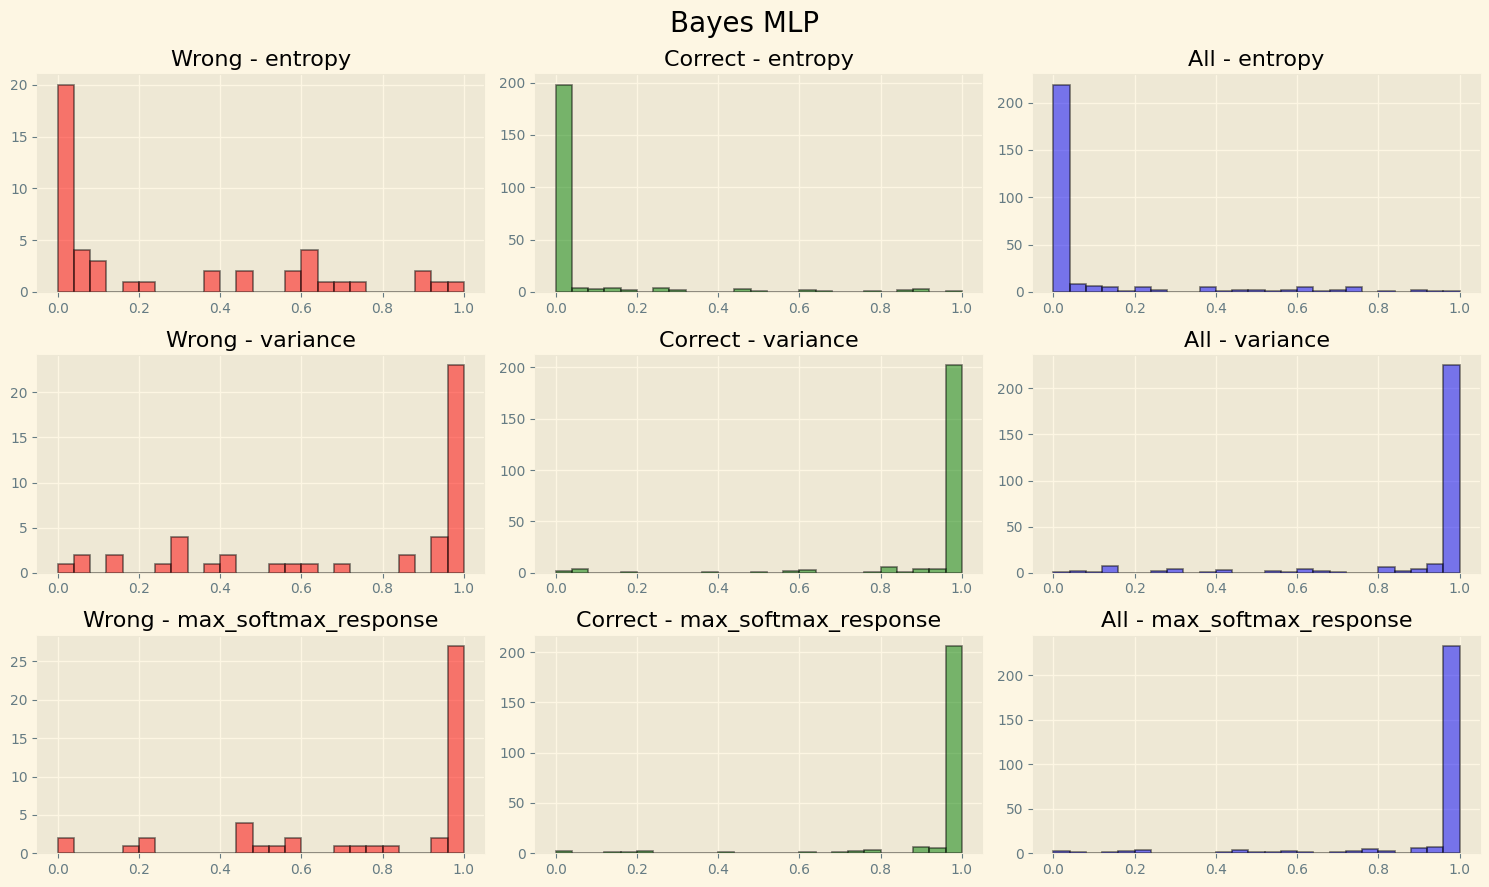

In [ ]:
fig, axes = plt.subplots(len(uncertainties_bayes['correct'].keys()), 3, figsize=(15, 9))
for ax, measure in zip(axes, uncertainties_bayes['correct'].keys()):
    ax[0] .set_title(f"Wrong - {measure}")
    ax[0].hist(uncertainties_bayes['wrong'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
    ax[1] .set_title(f"Correct - {measure}")
    ax[1].hist(uncertainties_bayes['correct'][measure], color="green", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
    ax[2] .set_title(f"All - {measure}")
    ax[2].hist(uncertainties_bayes['all'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
fig.suptitle("Bayes MLP", fontsize=20)
plt.tight_layout()

In [ ]:
ROOTDIR_DATASET_ANOMALY = "/content/OurProject/kuka_dataset/collisions"

In [ ]:
!ls {ROOTDIR_DATASET_ANOMALY}

20220811_collisions_timestamp_wo_cal.xlsx   rec5_20220811_rbtc_0.1s.csv
20220811_collisions_timestamp.xlsx	    rec5_collision_20220811_rbtc_0.1s.metadata
rec1_20220811_rbtc_0.1s.csv		    rec6_20220811_rbtc_0.1s.csv
rec1_collision_20220811_rbtc_0.1s.metadata


In [ ]:
collisions = pd.read_excel(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp_wo_cal.xlsx"))
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

In [ ]:
collisions

,Inizio/fine,Timestamp
0,i,2022-08-11 16:12:46.120
1,f,2022-08-11 16:12:50.590
2,i,2022-08-11 16:12:59.320
3,f,2022-08-11 16:13:03.370
4,i,2022-08-11 16:13:23.940
...,...,...
77,f,2022-08-11 19:09:28.580
78,i,2022-08-11 19:09:38.750
79,f,2022-08-11 19:09:42.830
80,i,2022-08-11 19:09:53.950


In [ ]:
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_20220811_rbtc_0.1s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_0.1s.metadata") for r in [1, 5]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.



In [ ]:
start_time = time.time()
df_features_collision = get_features_ts("statistical", df_action, df_meta, 10, action2int)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(2,2)=[true,1,0] 2022-08-11 14:02:00.409000 : 2022-08-11 14:02:11.147000.
Skipped feature extraction for pickFromPallet(2,2)=[true,1,0] 2022-08-11 14:02:26.155000 : 2022-08-11 14:02:39.167000.
Skipped feature extraction for pickFromPallet(2,2)=[true,1,0] 2022-08-11 14:02:54.246000 : 2022-08-11 14:03:07.190000.
Skipped feature extraction for placeToPallet(1,2)=[true,0] 2022-08-11 14:02:11.147000 : 2022-08-11 14:02:26.155000.
Skipped feature extraction for placeToPallet(1,2)=[true,0] 2022-08-11 14:02:39.167000 : 2022-08-11 14:02:54.246000.
Skipped feature extraction for placeToPallet(1,2)=[true,0] 2022-08-11 14:03:07.190000 : 2022-08-11 14:03:18.196000.
Skipped feature extraction for moveOverPallet(2,1)=[true,0] 2022-08-11 14:03:18.196000 : 2022-08-11 14:03:27.206000.
Skipped feature extraction for moveOverPallet(2,1)=[true,0] 2022-08-11 14:03:36.225000 : 2022-08-11 14:03:47.207000.
Skipped feature extraction for moveOverPallet(2,1)=[true,0] 2

In [ ]:
df_features_collision.isnull().values.any()

True

In [ ]:
df_features_collision_nonan = df_features_collision.fillna(0)

In [ ]:
X_collision = df_features_collision_nonan.drop(["label", "start", "end"], axis=1)
y_collision = df_features_collision_nonan["label"]

In [ ]:
X_collision = pd.DataFrame(selector_variance.transform(scaler.transform(X_collision)),
                           columns=X_collision.columns.values[selector_variance.get_support()])
X_collision.drop(corr_features, inplace=True, axis=1)
X_collision = X_collision[selected_features].copy()

In [ ]:
preds_array_collisions = multiple_predictions(n_mc, X_collision)
preds_bayes_mean_collision = np.mean(np.array(preds_array_collisions), axis=0)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
uncertainties_bayes = dict()
uncertainties_bayes["correct"] = Confidence(preds_array_collisions.mean(axis=0)[(preds_bayes_mean_collision.argmax(axis=1) == y_collision), :]).compute_uncertainty_metrics()
uncertainties_bayes["wrong"] = Confidence(preds_array_collisions.mean(axis=0)[(preds_bayes_mean_collision.argmax(axis=1) != y_collision), :]).compute_uncertainty_metrics()
uncertainties_bayes["all"] = Confidence(preds_array_collisions.mean(axis=0)).compute_uncertainty_metrics()

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


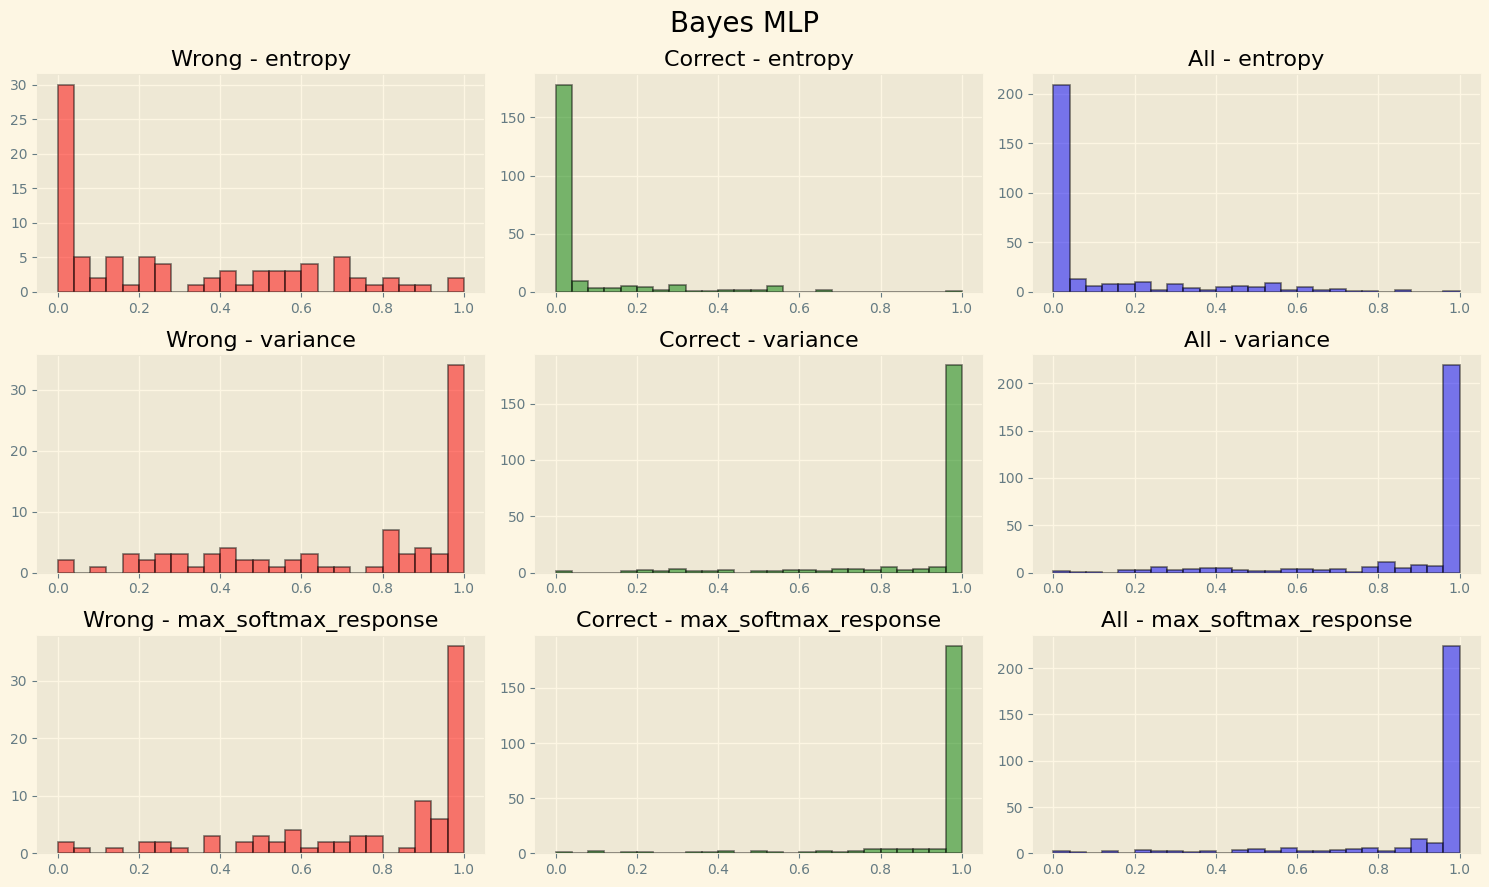

In [ ]:
fig, axes = plt.subplots(len(uncertainties_bayes['correct'].keys()), 3, figsize=(15, 9))
for ax, measure in zip(axes, uncertainties_bayes['correct'].keys()):
    ax[0] .set_title(f"Wrong - {measure}")
    ax[0].hist(uncertainties_bayes['wrong'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
    ax[1] .set_title(f"Correct - {measure}")
    ax[1].hist(uncertainties_bayes['correct'][measure], color="green", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
    ax[2] .set_title(f"All - {measure}")
    ax[2].hist(uncertainties_bayes['all'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5);
fig.suptitle("Bayes MLP", fontsize=20)
plt.tight_layout()

In [ ]:
anomaly_indexes = list()
for anomaly in collisions_init:
  id = 0
  for _, row in df_features_collision_nonan.iterrows():
    if anomaly >= row['start'] and anomaly <= row['end']:
      anomaly_indexes.append(id)
    id += 1

y_test = np.zeros((len(df_features_collision_nonan),))
y_test[anomaly_indexes] = 1

entropy


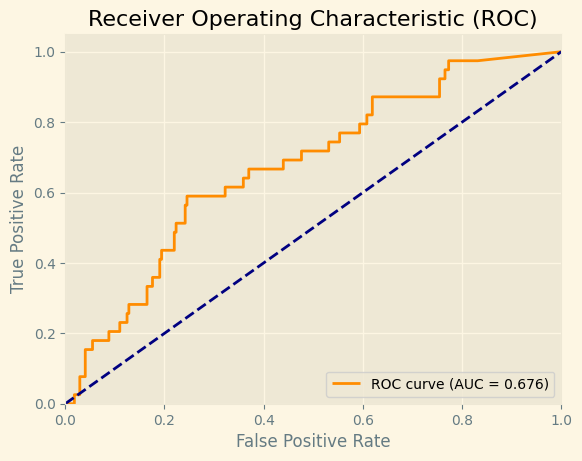

variance


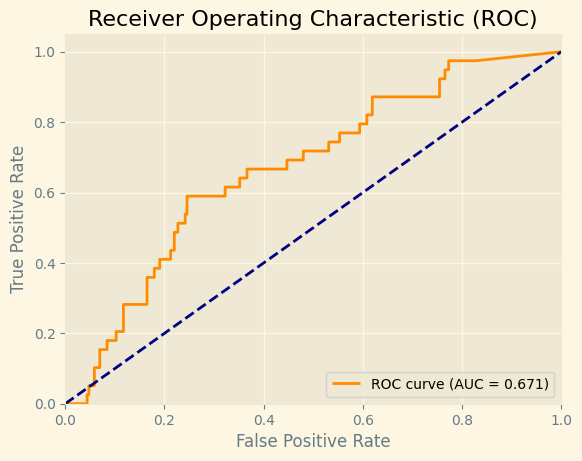

max_softmax_response


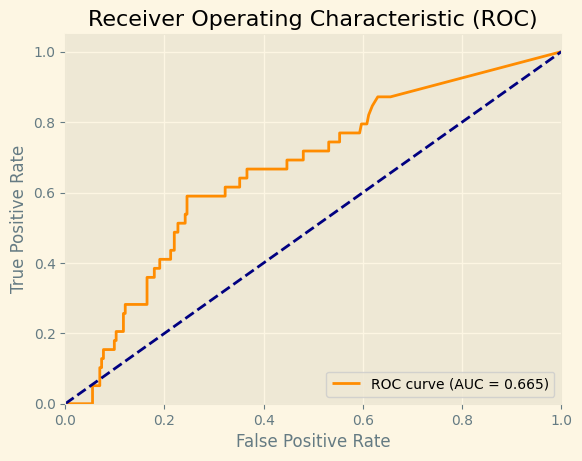

In [ ]:
for confidence_metric in uncertainties_bayes['correct'].keys():
    confidence = uncertainties_bayes['all'][confidence_metric]
    print(confidence_metric)
    if confidence_metric == "entropy":
        confidence = 1- confidence

    # Step 4: Compute ROC curve and AUC score
    fpr_by, tpr_by, thresholds = roc_curve(y_test, 1-confidence)  # fpr = False positive rate, tpr = True positive rate
    roc_auc = auc(fpr_by, tpr_by)  # Compute Area Under the Curve (AUC)

    # Save fpr and tpr as a .npz file
    np.savez(f'/content/OurProject/fpr_tpr_by_{confidence_metric}.npz', fpr=fpr_by, tpr=tpr_by)


    # Step 5: Plot ROC curve
    plt.figure()
    plt.plot(fpr_by, tpr_by, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

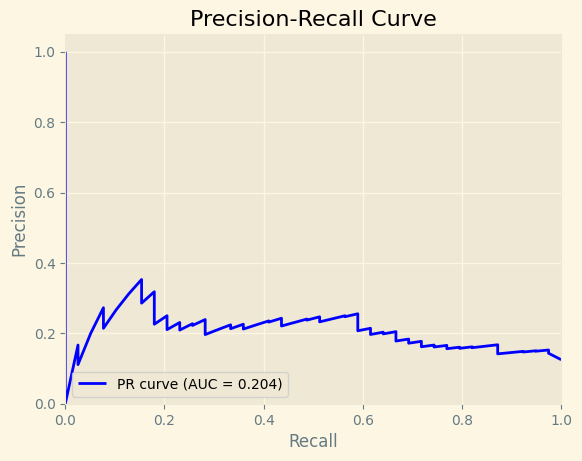

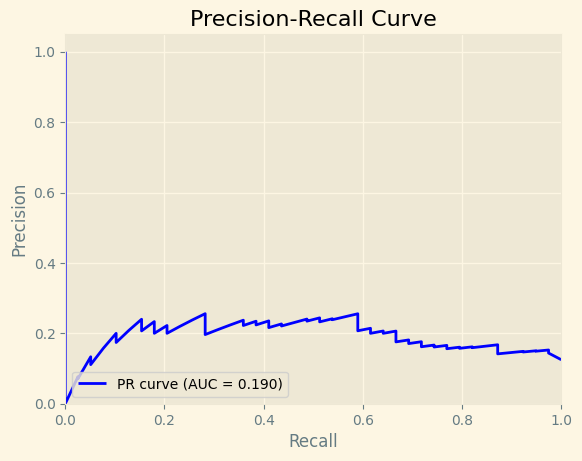

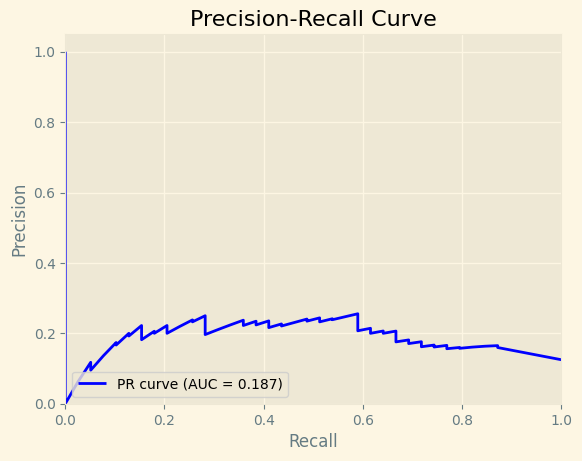

In [ ]:
for confidence_metric in uncertainties_bayes['correct'].keys():
    confidence = uncertainties_bayes['all'][confidence_metric]
    if confidence_metric == "entropy":
        confidence = 1- confidence

    # Step 4: Compute Precision-Recall curve and AUC score
    precision_by, recall_by, thresholds = precision_recall_curve(y_test, 1-confidence)
    pr_auc = auc(recall_by, precision_by)  # Compute Area Under the PR Curve (AUPRC)

    np.savez(f'/content/OurProject/pr_rc_by_{confidence_metric}.npz', precision=precision_by, recall=recall_by)

    # Step 5: Plot Precision-Recall curve
    plt.figure()
    plt.plot(recall_by, precision_by, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

In [ ]:
roc_dict = dict()
for confidence_metric in uncertainties_bayes['correct'].keys():
    print(confidence_metric)
    confidence = uncertainties_bayes['all'][confidence_metric]
    if confidence_metric == "entropy":
        confidence = 1- confidence
    sens = list()
    fpr = list()
    for threshold in np.arange(0, 1, 0.1):
        df_not_confident = df_features_collision_nonan[confidence <= threshold]
        anomaly_indexes = list()
        tp = 0
        for anomaly in collisions_init:
            for index, row in df_not_confident.iterrows():
                if anomaly >= row['start'] and anomaly <= row['end']:
                    anomaly_indexes.append(index)
                    tp += 1

        cm_anomaly = np.zeros((2, 2))
        n_samples = len(df_features_collision_nonan)
        n_not_collisions = n_samples - len(collisions_init)
        n_detected = len(df_not_confident)

        fp = n_detected - tp
        fn = len(collisions_init) - tp
        tn = n_not_collisions - fp
        cm_anomaly[0][0] = tn
        cm_anomaly[1][1] = tp
        cm_anomaly[0][1] = fp
        cm_anomaly[1][0] = fn
        sens.append(tp / (tp + fn))
        fpr.append(1 - tn / (fp + tn))

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

        try:
            f1 = 2 * (precision*recall/(precision+recall))
        except ZeroDivisionError:
            f1 = 0

        print(f"f1: {f1} @ {threshold})")

    roc_dict[confidence_metric] = (fpr, sens)

entropy
f1: 0 @ 0.0)
f1: 0 @ 0.1)
f1: 0 @ 0.2)
f1: 0 @ 0.30000000000000004)
f1: 0.14285714285714285 @ 0.4)
f1: 0.1971830985915493 @ 0.5)
f1: 0.24096385542168675 @ 0.6000000000000001)
f1: 0.25806451612903225 @ 0.7000000000000001)
f1: 0.3119266055045872 @ 0.8)
f1: 0.34375 @ 0.9)
variance
f1: 0 @ 0.0)
f1: 0 @ 0.1)
f1: 0 @ 0.2)
f1: 0.06896551724137931 @ 0.30000000000000004)
f1: 0.17391304347826086 @ 0.4)
f1: 0.20512820512820515 @ 0.5)
f1: 0.28235294117647053 @ 0.6000000000000001)
f1: 0.2553191489361702 @ 0.7000000000000001)
f1: 0.29126213592233013 @ 0.8)
f1: 0.336 @ 0.9)
max_softmax_response
f1: 0 @ 0.0)
f1: 0 @ 0.1)
f1: 0 @ 0.2)
f1: 0 @ 0.30000000000000004)
f1: 0.06896551724137931 @ 0.4)
f1: 0.06451612903225808 @ 0.5)
f1: 0.18666666666666668 @ 0.6000000000000001)
f1: 0.19753086419753088 @ 0.7000000000000001)
f1: 0.2553191489361702 @ 0.8)
f1: 0.30357142857142855 @ 0.9)


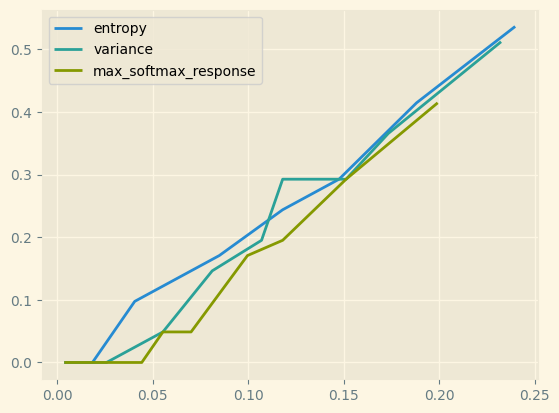

In [ ]:
fig, ax = plt.subplots(1, 1)
for confidence_metric in uncertainties_bayes['correct'].keys():
    ax.plot(roc_dict[confidence_metric][0], roc_dict[confidence_metric][1], label=confidence_metric)
ax.legend();

# USAD

# Data load

In [ ]:
# Set widnow size and k for point adjustment. 1 is f1, 0 is f1_pa

window_size = 20
k_pa = 0

In [ ]:
from Models.lstm_vae.data import get_data_windows

# Get data for training, calibration and testing in form of numpy arrays. Already windowed and normalized.
data_train, data_cal, label_cal, data_test, label_test = get_data_windows(window_size, k_pa)

print(data_train.shape)
print(data_cal.shape, label_cal.shape)
print(data_test.shape, label_test.shape)

Reading training data...
Reading calibration data...
Reading test data...
Reading collisions data...
Normalizing data...
Getting windows for training data...
Getting windows and labels for calibration data...
Getting windows and labels for test data...
(95795, 20, 55)
(3480, 20, 55) (3480,)
(30755, 20, 55) (30755,)


In [ ]:
from Models.usad.utils import *
from Models.usad.usad import *

device = get_default_device()

## Training

In [ ]:
BATCH_SIZE =  256
N_EPOCHS = 100
hidden_size = 50

In [ ]:
w_size=data_train.shape[1]*data_train.shape[2]
z_size=data_train.shape[1]*hidden_size

windows_normal_train = data_train[:int(np.floor(.8 *  data_train.shape[0]))]
windows_normal_val = data_train[int(np.floor(.8 *  data_train.shape[0])):int(np.floor(data_train.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [ ]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0809, val_loss2: 0.0820
Epoch [1], val_loss1: 0.0921, val_loss2: -0.0090
Epoch [2], val_loss1: 0.0950, val_loss2: -0.0429
Epoch [3], val_loss1: 0.0933, val_loss2: -0.0557
Epoch [4], val_loss1: 0.0944, val_loss2: -0.0660
Epoch [5], val_loss1: 0.1110, val_loss2: -0.0849
Epoch [6], val_loss1: 0.1152, val_loss2: -0.0942
Epoch [7], val_loss1: 0.1128, val_loss2: -0.0943
Epoch [8], val_loss1: 0.1084, val_loss2: -0.0933
Epoch [9], val_loss1: 0.1095, val_loss2: -0.0959
Epoch [10], val_loss1: 0.1095, val_loss2: -0.0972
Epoch [11], val_loss1: 0.1091, val_loss2: -0.0981
Epoch [12], val_loss1: 0.1096, val_loss2: -0.0999
Epoch [13], val_loss1: 0.1095, val_loss2: -0.1007
Epoch [14], val_loss1: 0.1112, val_loss2: -0.1030
Epoch [15], val_loss1: 0.1194, val_loss2: -0.1109
Epoch [16], val_loss1: 0.1853, val_loss2: -0.1717
Epoch [17], val_loss1: 0.1910, val_loss2: -0.1827
Epoch [18], val_loss1: 0.1831, val_loss2: -0.1757
Epoch [19], val_loss1: 0.1823, val_loss2: -0.1743
Epoch [20],

In [ ]:
#!mkdir "trained_models/USAD"
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, f"trained_models/USAD/model.pth")

## Model load

In [ ]:
model = UsadModel(w_size, z_size)
model = to_device(model,device)

checkpoint = torch.load("trained_models/USAD/model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<ipython-input-13-0b327816f62e>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("trained_models/USAD/model.pth")


<All keys matched successfully>

## Model Calibration

In [ ]:
cal_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(data_cal).float().view(([data_cal.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
results=testing(model,cal_loader,alpha=0.9,beta=0.1)
score_cal=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [ ]:
score_cal = score_cal.reshape(-1, 1)
score_cal.shape

(3480, 1)

In [ ]:
optimize = True
param_grid = {'estimator__C': np.logspace(0, 5, 6), 'estimator__gamma': np.logspace(-5, 0, 6)}

if optimize:
  cal_search = GridSearchCV(CalibratedClassifierCV(SVC(probability=True), cv=3), param_grid, cv=3, verbose=1, scoring='f1')
  cal_search.fit(score_cal, label_cal)
  cal_model = cal_search.best_estimator_
  print(cal_search.best_params_)
else:
  cal_model = CalibratedClassifierCV(SVC(probability=True, C=10, gamma=1e-3))
  cal_model.fit(score_cal, label_cal[:score_cal.shape[0]])

Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'estimator__C': 100000.0, 'estimator__gamma': 1.0}


## Model Test

In [ ]:
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(data_test).float().view(([data_test.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
def evaluate_model(label_test, y_pred_test, y_score_test, verbose = True) :

  f1 = sklearn.metrics.f1_score(label_test, y_pred_test)

  fpr_usad, tpr_usad, thresholds = sklearn.metrics.roc_curve(label_test, y_score_test)
  roc_auc = sklearn.metrics.auc(fpr_usad, tpr_usad)

  if verbose:
    plt.plot(fpr_usad, tpr_usad, labael='ROC curve (area = %0.4f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.show()

  precision_usad, recall_usad, thresholds = sklearn.metrics.precision_recall_curve(label_test, y_score_test)
  prc_auc = sklearn.metrics.auc(recall_usad, precision_usad)

  if verbose:
    plt.plot(recall_usad, precision_usad, label='PRC curve (area = %0.4f)' % prc_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend()
    plt.show()

  # Save fpr and tpr as a .npz file
  np.savez('/content/OurProject/fpr_tpr_USAD.npz', fpr=fpr_usad, tpr=tpr_usad)
  np.savez('/content/OurProject/pr_rc_USAD.npz', precision=precision_usad, recall=recall_usad)

  return f1, roc_auc, prc_auc

In [ ]:
results=testing(model,test_loader,alpha=0.9,beta=0.1)
score_test=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])
score_test = score_test.reshape(-1, 1)
score_test.shape

(30755, 1)

In [ ]:
label_test = label_test[:score_test.shape[0]]

y_pred_test = cal_model.predict(score_test)
y_score_test = cal_model.predict_proba(score_test)[:, 1]

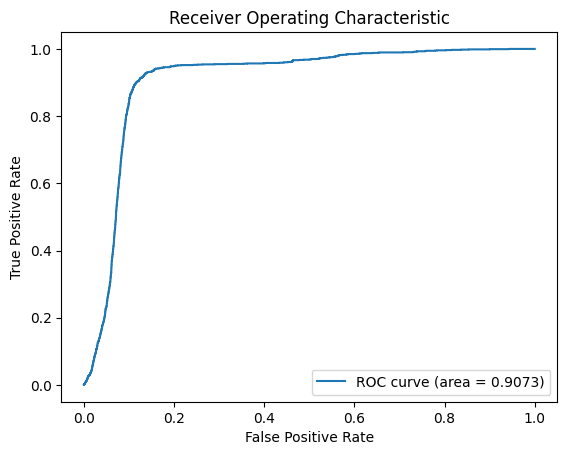

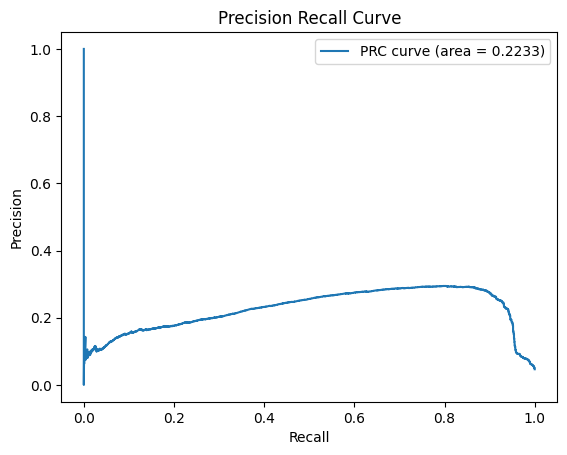

In [ ]:
f1, roc_auc, prc_auc = evaluate_model(label_test, y_pred_test, y_score_test, verbose = True)

In [ ]:
print(f"{f1} {roc_auc} {prc_auc}")

0.42989056087551303 0.9073223495633903 0.2233434794010386


# LSTM_VAE

# Model load

In [ ]:
# Set parameters to load the model
x_dim = data_cal.shape[2]
lstm_h_dim = 10
z_dim = 10

In [ ]:
!ls

 Benchmarks     README.md	     'test_script OBSOLETO.ipynb'
 kuka_dataset   Stuff		      trained_models
 Models         test_script_2.ipynb   train_LSTM_VAE.ipynb


In [ ]:
from Models.lstm_vae.model import LSTM_VAE

model = LSTM_VAE(window_size, x_dim, lstm_h_dim, z_dim, dtype='float32')
model.compile()
model.load_weights('./trained_models/lstm_vae/lstm_vae_ckpt.weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Model calibration

In [ ]:
data_cal.shape

(3480, 20, 55)

In [ ]:
score_cal = model.anomaly_score(data_cal)
label_cal = label_cal[:score_cal.shape[0]]

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [ ]:
score_cal.shape, label_cal.shape

((3456, 55), (3456,))

In [ ]:
print(data_cal)

[[[3.23831950e-03 1.60025602e-01 2.61105324e-01 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [3.23831950e-03 1.60025602e-01 2.61105324e-01 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [3.23831950e-03 1.60025602e-01 2.61105324e-01 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [9.97640993e-04 1.91067464e-01 2.61105324e-01 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [9.97640993e-04 1.91067464e-01 2.61105324e-01 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [9.97640993e-04 1.91067464e-01 2.61105324e-01 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[3.23831950e-03 1.60025602e-01 2.61105324e-01 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [3.23831950e-03 1.60025602e-01 2.61105324e-01 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [3.23831950e-03 1.60025602e-01 2.61105324e-01 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  ...
  [9.97640993e-04 1.91067464e-01 2.61105324e-01 ... 0.00000000e+00
   0.00000

In [ ]:
# prompt: conta quanti valori Nan sono presenti in score_cal

np.isnan(score_cal).sum()


168685

In [ ]:
optimize = False
param_grid = {'estimator__C': np.logspace(0, 5, 6), 'estimator__gamma': np.logspace(-5, 0, 6)}

if optimize:
  cal_search = GridSearchCV(CalibratedClassifierCV(SVC(probability=True), cv=3), param_grid, cv=3, verbose=1, scoring='f1')
  cal_search.fit(score_cal, label_cal)
  cal_model = cal_search.best_estimator_
  print(cal_search.best_params_)
else:
  cal_model = CalibratedClassifierCV(SVC(probability=True, C=1, gamma=1e-4))
  cal_model.fit(score_cal, label_cal[:score_cal.shape[0]])

ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Model evaluation

In [ ]:
def evaluate_model(label_test, y_pred_test, y_score_test, verbose = True) :
  score_test = model.anomaly_score(data_test)
  label_test = label_test[:score_test.shape[0]]

  y_pred_test = cal_model.predict(score_test)
  y_score_test = cal_model.predict_proba(score_test)[:, 1]

  f1 = sklearn.metrics.f1_score(label_test, y_pred_test)

  fpr, tpr, thresholds = sklearn.metrics.roc_curve(label_test, y_score_test)
  roc_auc = sklearn.metrics.auc(fpr, tpr)

  if verbose:
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.show()

  precison, recall, thresholds = sklearn.metrics.precision_recall_curve(label_test, y_score_test)
  prc_auc = sklearn.metrics.auc(recall, precison)

  if verbose:
    plt.plot(recall, precison, label='PRC curve (area = %0.4f)' % prc_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend()
    plt.show()

  return f1, roc_auc, prc_auc

In [ ]:
score_test = model.anomaly_score(data_test)
label_test = label_test[:score_test.shape[0]]

y_pred_test = cal_model.predict(score_test)
y_score_test = cal_model.predict_proba(score_test)[:, 1]

In [ ]:
f1, roc_auc, prc_auc = evaluate_model(label_test, y_pred_test, y_score_test, verbose = True)

In [ ]:
print(f"f1: {f1}, roc_auc: {roc_auc}, prc_auc: {prc_auc}")



```
# Questo è formattato come codice
```

#TimeVQVAE

In [ ]:
#@title Install...
!pip install -r '/content/OurProject/Models/TimeVQVAE-main/requirements.txt'

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.0 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=e87c2d80e9bfaac70108527033fbbac9db4aa915ad84f9a860ca5153cf85393a
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
#@title Imports...
import sys
VQVAE_PATH = 'Models/TimeVQVAE-main'
sys.path.append(os.path.join(os.getcwd(),VQVAE_PATH))
from stage1 import *
from utils import *
from experiments.exp_vq_vae import ExpVQVAE
from tqdm import tqdm

dataset_name = 'KUKA'
config = load_yaml_param_settings(os.path.join(VQVAE_PATH, 'configs/config.yaml'))

/content/OurProject/Models/TimeVQVAE-main/vector_quantization/vq.py:194: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)


In [ ]:
#@title Datasets...
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
pd.options.mode.copy_on_write = True
from datasets.kuka_dataset.KukaDataset import KukaDataset
from tqdm import tqdm

dataset_name = 'KUKA'
TRAIN_DATA_PATH = "kuka_dataset/normal"
CAL_DATA_PATH = "kuka_dataset/collisions"#take only file 6
TEST_DATA_PATH = "kuka_dataset/collisions"#take only files 1, 5

categories = np.array(['Low', 'High']).reshape(-1, 1)
encoder = OneHotEncoder(dtype=np.float32)
encoder.fit(categories)

train_dataset = KukaDataset(os.path.join(os.getcwd(),TRAIN_DATA_PATH), test=False, config=config, keep_faulty=False, risk_encoder=encoder, drop_default=True)
#print(train_dataset.kept_columns)
cal_dataset = KukaDataset(os.path.join(os.getcwd(),CAL_DATA_PATH), test=False, config=config, keep_faulty=True, drop_default=True,
                          columns_to_keep=train_dataset.kept_columns, risk_encoder=encoder)
test_dataset = KukaDataset(os.path.join(os.getcwd(),TEST_DATA_PATH), test=True, config=config, keep_faulty=True, drop_default=True,
                          columns_to_keep=train_dataset.kept_columns, risk_encoder=encoder)
config['dataset']['in_channels'] = len(train_dataset.kept_columns) - len(train_dataset.header_columns) - 1

reading data...
preprocessing ... 
windowing ts 1/4
windowing ts 2/4
windowing ts 3/4
windowing ts 4/4
files were read...
95739 (20, 55)
--- Train Dataset ---
df len is: 95739 window shape is: (20, 55)
reading anomalies...
start adding high risk
found the excel and loaded it...
reading data...
preprocessing ... 
windowing ts 1/1
files were read...
3481 (20, 55)
--- Train Dataset ---
df len is: 3481 window shape is: (20, 55)
reading anomalies...
start adding high risk
found the excel and loaded it...
reading data...
windowing ts 1/2
windowing ts 2/2
files were read...
30737 (20, 55)
--- Test Dataset ---
df len is: 30737 window shape is: (20, 55)


In [ ]:
#@title Data Loaders...
batch_size = config['dataset']['batch_sizes']['stage1']

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
cal_data_loader = DataLoader(cal_dataset, batch_size=1)
test_data_loader = DataLoader(test_dataset, batch_size=1)

In [ ]:
config['trainer_params']['input_length'], config['dataset']['in_channels']

(20, 55)

In [ ]:
#@title Loading TimeVQVAE
exp_vqvae = ExpVQVAE(config['trainer_params']['input_length'], config, len(train_data_loader.dataset))

models_dir = 'saved_models_55ft_w20'
#models_dir = 'saved_models_55ft_w100'
#models_dir = 'saved_models_70ft_w100'
CKPT_PATH = '/content/OurProject/trained_models/TimeVQVAE'

# load
fname = f'vq_model_l-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),CKPT_PATH), models_dir, fname)
exp_vqvae.vq_model_l.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'vq_model_h-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),CKPT_PATH), models_dir, fname)
exp_vqvae.vq_model_h.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'encoder_l-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),CKPT_PATH), models_dir, fname)
exp_vqvae.encoder_l.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'encoder_h-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),CKPT_PATH), models_dir, fname)
exp_vqvae.encoder_h.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'decoder_l-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),CKPT_PATH), models_dir, fname)
exp_vqvae.decoder_l.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'decoder_h-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),CKPT_PATH), models_dir, fname)
exp_vqvae.decoder_h.load_state_dict(torch.load(ckpt_fname), strict=False)

exp_vqvae.eval()

<ipython-input-52-516a59635272>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp_vqvae.vq_model_l.load_state_dict(torch.load(ckpt_fname), strict=False)


ExpVQVAE(
  (encoder_l): VQVAEEncoder(
    (encoder): Sequential(
      (0): VQVAEEncBlock(
        (block): Sequential(
          (0): Conv2d(110, 128, kernel_size=(3, 4), stride=(1, 2), padding=(1, 1), padding_mode=replicate)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
      (1): Sequential(
        (0): ResBlock(
          (convs): Sequential(
            (0): LeakyReLU(negative_slope=0.01)
            (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): LeakyReLU(negative_slope=0.01)
            (4): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ResBlock(
   

In [ ]:
#@title Estimates for calibration...
# KEEP BATCH SIZE = 1 HERE, PLEASE
#mapping = {1: 'Low', 0: 'High'}
all_losses = []
window_label_pos = config['trainer_params']['input_length'] - 1
for batch in tqdm(cal_data_loader): #iterating through test ds with step B

    x , y = batch[0], batch[1]
    #x = x.to(gpu_device_idx) #comment if using the CPU

    recons_loss, _, _ = exp_vqvae.forward((x,))

    lf_time = recons_loss['LF.time'].detach().item()
    hf_time = recons_loss['HF.time'].detach().item()
    lf_timefreq = recons_loss['LF.timefreq'].detach().item()
    hf_timefreq = recons_loss['HF.timefreq'].detach().item()

    #print(y.shape)
    #curr_label = mapping[torch.argmax(y[0, :, 0]).item()]
    curr_label_encoded = y[0, :, 0].unsqueeze(0).numpy()
    curr_label = encoder.inverse_transform(curr_label_encoded)[0, 0]

    all_losses.append((np.array([lf_time, hf_time, lf_timefreq, hf_timefreq]), curr_label))

# Separate the data and labels
data = [tup[0] for tup in all_losses]
labels = [tup[1] for tup in all_losses]

# Vstack the data to create a 2-dimensional numpy array
data_array = np.vstack(data)

# Convert the labels to a 1-dimensional numpy array
labels_array = np.array(labels)
labels_array = np.where(labels_array == "High", 0, 1)

  0%|          | 0/3481 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:666: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:836.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]
/content/OurProject/Models/TimeVQVAE-main/utils/__init__.py:228: UserWarning: A window was not provided. A rectangular window will be applied.Please provide the same window used by stft to make the inversion lossless.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at ../aten/src/ATen/native/Spec

In [ ]:
data_array.shape, labels_array.shape, data_array[0], labels_array[0], type(data_array), type(labels_array), np.unique(labels_array)

((3481, 4),
 (3481,),
 array([3.15734595e+03, 4.82431269e+00, 2.28811738e+04, 1.05611975e+03]),
 1,
 numpy.ndarray,
 numpy.ndarray,
 array([0, 1]))

In [ ]:
optimize = False
param_grid = {'estimator__C': np.logspace(0, 5, 6), 'estimator__gamma': np.logspace(-5, 0, 6)}

if optimize:
  cal_search = GridSearchCV(CalibratedClassifierCV(SVC(probability=True), cv=3), param_grid, cv=3, verbose=1, scoring='f1')
  cal_search.fit(data_array, labels_array)
  cal_vqvae = cal_search.best_estimator_
  print(cal_search.best_params_)
else:
  cal_vqvae = CalibratedClassifierCV(SVC(probability=True, C=1.0, gamma=1e-5))
  cal_vqvae.fit(data_array, labels_array[:data_array.shape[0]])

In [ ]:
def evaluate_model(label_test, y_pred_test, y_score_test, verbose = True) :

  f1 = sklearn.metrics.f1_score(label_test, y_pred_test)

  fpr, tpr, thresholds = sklearn.metrics.roc_curve(label_test, y_score_test)
  roc_auc = sklearn.metrics.auc(fpr, tpr)

  if verbose:
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.show()

  precison, recall, thresholds = sklearn.metrics.precision_recall_curve(label_test, y_score_test)
  prc_auc = sklearn.metrics.auc(recall, precison)

  if verbose:
    plt.plot(recall, precison, label='PRC curve (area = %0.4f)' % prc_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend()
    plt.show()

  # Save fpr and tpr as a .npz file
  np.savez('/content/OurProject/fpr_tpr_VQVAE.npz', fpr=fpr, tpr=tpr)
  np.savez('/content/OurProject/pr_rc_VQVAE.npz', precision=precison, recall=recall)

  return f1, roc_auc, prc_auc

In [ ]:
#@title Estimates for testing...
# KEEP BATCH SIZE = 1 HERE, PLEASE
#mapping = {1: 'Low', 0: 'High'}
test_losses = []
window_label_pos = config['trainer_params']['input_length'] - 1
for batch in tqdm(test_data_loader): #iterating through test ds with step B

    x , y = batch[0], batch[1]
    #x = x.to(gpu_device_idx) #comment if using the CPU

    recons_loss, _, _ = exp_vqvae.forward((x,))

    lf_time = recons_loss['LF.time'].detach().item()
    hf_time = recons_loss['HF.time'].detach().item()
    lf_timefreq = recons_loss['LF.timefreq'].detach().item()
    hf_timefreq = recons_loss['HF.timefreq'].detach().item()

    #print(y.shape)
    #curr_label = mapping[torch.argmax(y[0, :, 0]).item()]
    curr_label_encoded = y[0, :, 0].unsqueeze(0).numpy()
    curr_label = encoder.inverse_transform(curr_label_encoded)[0, 0]

    test_losses.append((np.array([lf_time, hf_time, lf_timefreq, hf_timefreq]), curr_label))

# Separate the data and labels
data = [tup[0] for tup in test_losses]
labels = [tup[1] for tup in test_losses]

# Vstack the data to create a 2-dimensional numpy array
score_test = np.vstack(data)

# Convert the labels to a 1-dimensional numpy array
t_labels_array = np.array(labels)
t_labels_array = np.where(t_labels_array == "High", 0, 1)

y_pred_test = cal_vqvae.predict(score_test)
y_score_test = cal_vqvae.predict_proba(score_test)[:, 1]

100%|██████████| 30737/30737 [10:54<00:00, 46.97it/s]


In [ ]:
t_labels_array[:10], y_pred_test[:10], y_score_test[:10]#, t_labels_array.shape, y_pred_test.shape, y_score_test.shape

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0.91365548, 0.91365548, 0.91365548, 0.91365548, 0.91365548,
        0.91365548, 0.91365548, 0.91365548, 0.91365548, 0.91365548]))

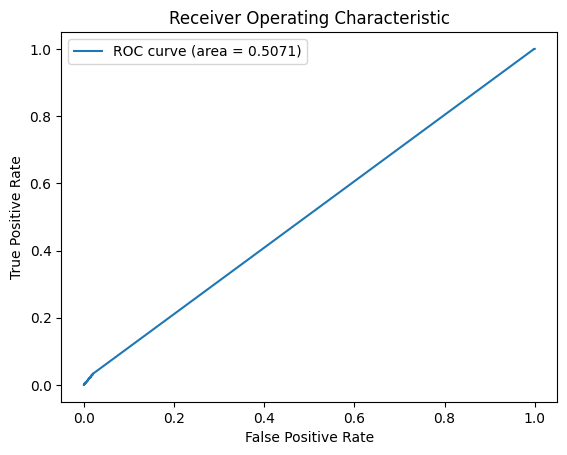

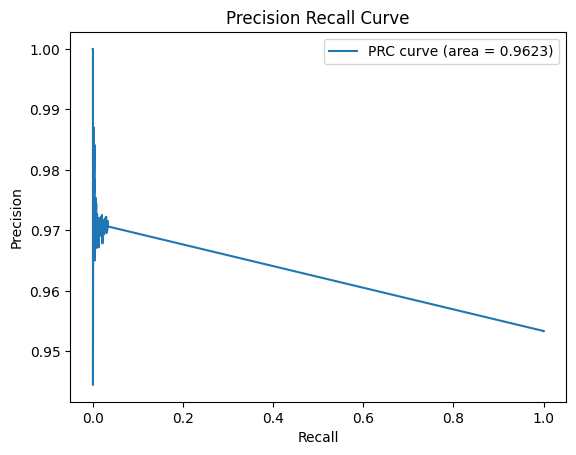

In [ ]:
f1, roc_auc, prc_auc = evaluate_model(t_labels_array, y_pred_test, y_score_test, verbose = True)

In [ ]:
print(f"f1: {f1}, roc_auc: {roc_auc}, prc_auc: {prc_auc}")

f1: 0.9760477047105071, roc_auc: 0.5071010600410908, prc_auc: 0.9623358148358153


# Telemanom



The Telemanom model utilizes Long Short-Term Memory (LSTM) neural networks to manage and analyze large volumes of telemetry data. This approach demonstrates how such networks can effectively handle the complexity and scale of the data. An innovative, unsupervised, and nonparametric method for setting anomaly thresholds has been introduced, designed during a pilot implementation for effective anomaly detection. The model also includes strategies to minimize false positives and presents key insights and lessons learned during development. The original model has been modified to accept various configuration parameters directly as arguments at model startup, and it has been converted from TensorFlow to PyTorch. [Link original paper](https://arxiv.org/pdf/1802.04431)


**Model Training**
---

The model undergoes a training phase of 20 epochs for each channel. During this training phase, the model learns the normal behavior of the channel by predicting the current timestamp, considering approximately 300 samples from previous timestamps (a hyperparameter) for prediction. Before the training phase, each channel undergoes a model weight calibration. Once the training cycles for each channel are completed, inference is conducted using a dataset containing anomalies to determine if the learned normal behavior deviates from that observed in the anomaly dataset. The various anomalies predicted across the channels are then summed and pruned based on their scores; anomalies falling below a dynamically calculated threshold are disregarded.

Below the list of arguments accepted by the model:

1. `--run_id`: Specifies a directory path in the format `trained_models/telemanom/{run_id}` to locate parameters for initialization. (Type: string, Default: None)
2. `--batch_size`: Number of values to evaluate in each batch. (Type: integer)
3. `--window_size`: Number of consecutive batches used in the calculation of errors. (Type: integer)
4. `--smoothing_perc`: Determines the size of the window used in EWMA smoothing. (Type: float)
5. `--error_buffer`: Number of values surrounding an error that are included in the sequence. (Type: integer)
6. `--l_s`: Minimum number of precedent telemetry data required for analysis. (Type: integer)
7. `--n_predictions`: Number of predictions per timestamp. (Type: integer)
8. `--activation`: Specifies the activation layer used in the model. (Type: string, Options : ["relu","sigmoid","leakyReLu"])
10. `--dropout`: Determines the dropout rate for various layers in the model. (Type: float)
11. `--weight_decay`: Specifies L2 regularization. (Type: float)
12. `--learning_rate`: Learning rate for the model. (Type: float)
13. `--lstm_batch_size`: Batch size for LSTM layers. (Type: integer)
14. `--layer_LSTM`: Specifies the number of LSTM layers to include in the model. (Type: integer)
15. `--epochs`: Number of epochs for training. (Type: integer)
16. `--p`: Minimum percentage decrease between the maximum errors in anomalous sequences. (Type: float)
17. `--save_on_drive`: If set, saves information on the connected drive. (Action: store_true)
18. `--skip_graphics`: If set, avoids creating graphical files for results. (Action: store_true)
20. `--train`: If set, applies training to the model. (Action: store_true)
21. `--predict`: Forces the model to generate new predictions; if not set, uses predictions from the `trained_models/telemanom/{run_id}`. (Action: store_true)
22. `--num_channels`: Number of channels to consider. (Type: integer)
23. `--threshold`: If set, calculates a dynamic threshold for the final anomalies. (Action: store_true)

These parameters provide detailed control over the model's configuration and operation, catering to a wide range of needs and applications.

**Note:** When the `--train` parameter is passed, the model is forced to execute the training phase. However, if there are existing model weights from a previous training session in the path `trained_models/telemanom/{run_id}`, those weights will be retrieved. Passing the `--train` parameter will cause the model to perform both the training phase and the final inference. It is important to note that the duration of the training phase can vary depending on the `--layer_LSTM` parameter and the number of layers per each LSTM, which is a hyperparameter defined in the model's `config.yaml`. Increasing the number of LSTM layers and the number of layers per LSTM can significantly alter the time required for training the model.

In [ ]:
!python "/content/OurProject/Models/telemanom/main.py" --train --predict --threshold --sample_rate 0.1s

**Model Inference**

If you wish to execute only the inference phase, bypassing the training phase, you must remove the `--train` parameter from the arguments (which otherwise forces the model to perform the training). However, to properly conduct the inference phase, the folder `trained_models/telemanom/{run_id}` must exist and contain at least the subfolders "models" (which holds the model weights for each channel) and "y_hat" (the predictions made by the model for various timestamps). If the `--predict` argument is passed, the model will load the channel-specific model weights from `trained_models/telemanom/{run_id}/models` to make predictions. If `--predict` is not passed, it will retrieve previous predictions from `trained_models/telemanom/{run_id}/y_hat` to calculate the model's accuracy without recalculating the prediction.

Furthermore, the model saves configuration information and details about the model (such as the number of LSTM layers used and the number of layers per LSTM) in the path `trained_models/telemanom/{run_id}/info_model/info_model.txt`. For each step, the model saves both on-screen and in a log file the various outputs obtained during the run (log path: `trained_models/telemanom/{run_id}/{run_id}.log`).

To aid in visually understanding the prediction results of anomalies, logic has been implemented that saves a graph of both actual and predicted anomalies for each channel during the inference phase. Additionally, the various predictions are summed and pruned according to their score. The pruning of anomalies only occurs if the `--threshold` argument is passed; otherwise, the final anomaly pruning does not take place. The graphical results obtained for the various channels and the final model outcome are saved as .pdf files in the path `trained_models/telemanom/{run_id}/plot_predictions/`.

It is recommended to refer to both the on-screen logs and those saved in log files (which have the same results) for a better understanding of the model's behavior and to know where the various model results are stored; they should be comprehensive.

In [ ]:
!python "/content/OurProject/Models/telemanom/main.py" --predict --threshold --sample_rate 0.1s --run_id "2024-07-30_22.17.34"

Starting retrieving Kuka_v1 dataset from the path : /content/OurProject/kuka_dataset
Processing the directory collisions
Processing file: rec1_20220811_rbtc_0.1s.csv
Step : 0 - Sample Rate : 0.1s
Processing file: rec5_20220811_rbtc_0.1s.csv
Step : 1 - Sample Rate : 0.1s
Starting Extracting Dataset for Calibration from File : rec6_20220811_rbtc_0.1s.csv from the path : /content/OurProject/kuka_dataset/collisions/test/rec6_20220811_rbtc_0.1s.csv
Ended Extracting Dataset for Calibration from File : rec6_20220811_rbtc_0.1s.csv from the path : /content/OurProject/kuka_dataset/collisions/test/rec6_20220811_rbtc_0.1s.csv
Starting Extracting Labels Data from File : 20220811_collisions_timestamp.xlsx from the path : /content/OurProject/kuka_dataset/collisions/test/20220811_collisions_timestamp.xlsx
Starting Refactor Labels Data from File : /content/OurProject/kuka_dataset/collisions/20220811_collisions_timestamp.xlsx with TZ : -2H
Ended Refactor Labels.
Ended Extracting Labels Data 
Processing 

# Comparison

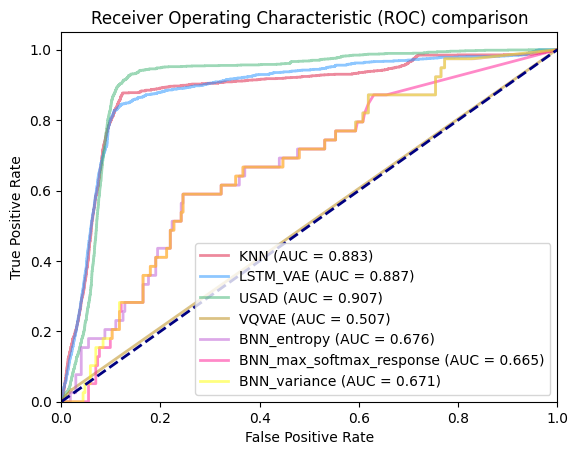

In [15]:
# Supponiamo che tu abbia le predizioni di "confidence" (probabilità) per ciascun modello
# confidence_models è una lista che contiene i valori di "confidence" per ciascun modello
ROOTDIR_FPR = "/content/OurProject"
name_list = ["KNN", "LSTM_VAE", "USAD", "VQVAE", "BNN_entropy", "BNN_max_softmax_response", "BNN_variance"]

fpr_list = [os.path.join(ROOTDIR_FPR, f"fpr_tpr_{f}.npz") for f in name_list]

# Colori diversi per i modelli
colors = ['#DC143C', '#1E90FF', '#3CB371', '#B8860B', '#BA55D3', '#FF1493', 'yellow']

plt.figure()

# Itera attraverso i modelli e calcola le ROC curve e AUC per ciascuno
for i, npz in enumerate(fpr_list):
    data = np.load(npz)
    fpr = data['fpr']
    tpr = data['tpr']
    roc_auc = auc(fpr, tpr)

    # Plotta la curva ROC per ciascun modello
    plt.plot(fpr, tpr, color=colors[i], lw=2, alpha=0.5, label=f'{name_list[i]} (AUC = {roc_auc:.3f})')

# Plotta la diagonale
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Imposta i limiti degli assi
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Titoli e etichette degli assi
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) comparison')

# Legenda
plt.legend(loc="lower right")

# Mostra il grafico
plt.show()

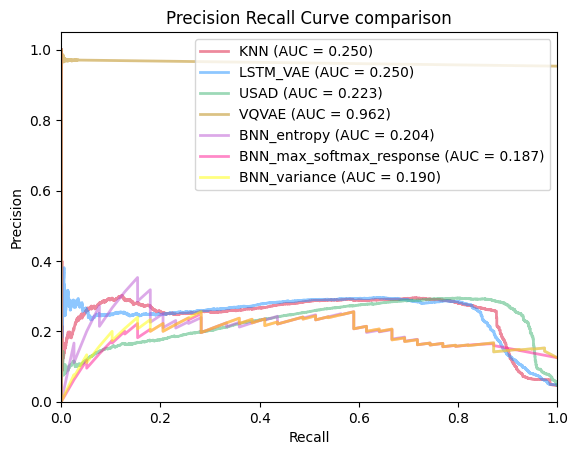

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

ROOTDIR_PRRC = "/content/OurProject"
name_list = ["KNN", "LSTM_VAE", "USAD", "VQVAE", "BNN_entropy", "BNN_max_softmax_response", "BNN_variance"]

pr_rc_list = [os.path.join(ROOTDIR_PRRC, f"pr_rc_{f}.npz") for f in name_list]

# Nuova palette di colori
colors = ['#DC143C', '#1E90FF', '#3CB371', '#B8860B', '#BA55D3', '#FF1493', 'yellow']

# Crea la figura
plt.figure()

# Itera attraverso i modelli e calcola le ROC curve e AUC per ciascuno
for i, npz in enumerate(pr_rc_list):
    data = np.load(npz)
    pr = data['precision']
    rc = data['recall']
    pr_rc_auc = auc(rc, pr)

    # Plotta la curva ROC per ciascun modello
    plt.plot(rc, pr, color=colors[i], lw=2, alpha=0.5, label=f'{name_list[i]} (AUC = {pr_rc_auc:.3f})')

# Imposta i limiti degli assi
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Titoli e etichette degli assi
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve comparison')

# Legenda
plt.legend(loc="upper right")

# Mostra il grafico
plt.show()
